In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [2]:
# Step 1: Load Cleaned Data
df = pd.read_csv("../data/cleaned_online_retail.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [3]:
 # Step 2: Calculate RFM Features
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [4]:
# Step 3: Scale the RFM Values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


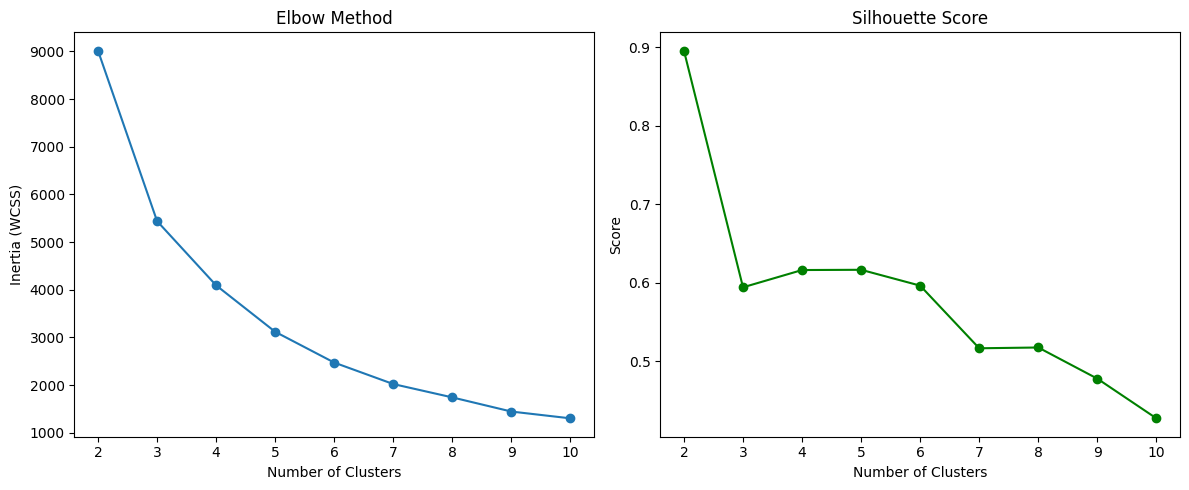

In [5]:
# Step 4: Find Best K Using Elbow Method & Silhouette Score
inertia = []
silhouette = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Plot Elbow Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (WCSS)")

plt.subplot(1, 2, 2)
plt.plot(K, silhouette, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")

plt.tight_layout()
plt.show()


In [6]:
# Step 5: Train KMeans with Best K
# Apply KMeans with K=4
best_k = 4
kmeans_model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans_model.fit_predict(rfm_scaled)

# Preview clustering
rfm.head()


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,1,77183.60,3
1,12347.0,2,7,4310.00,0
2,12348.0,75,4,1797.24,0
3,12349.0,19,1,1757.55,0
4,12350.0,310,1,334.40,1


In [7]:
# Step 6: Profile & Label Clusters
# Mean values for each cluster
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)
cluster_summary


,Recency,Frequency,Monetary
Cluster,,,
0,43.7,3.7,1359.0
1,248.1,1.6,480.6
2,7.4,82.5,127338.3
3,15.5,22.3,12709.1


In [8]:
# Using these mean values to label the clusters manually:
# Labeling based on RFM values
def label_segment(row):
    if row['Recency'] < 40 and row['Frequency'] > 10 and row['Monetary'] > 1000:
        return 'High-Value'
    elif row['Recency'] < 80 and row['Frequency'] > 4:
        return 'Regular'
    elif row['Recency'] > 180 and row['Frequency'] < 2:
        return 'At-Risk'
    else:
        return 'Occasional'

rfm['Segment'] = rfm.apply(label_segment, axis=1)
rfm[['CustomerID', 'Cluster', 'Segment']].head()


,CustomerID,Cluster,Segment
0,12346.0,3,At-Risk
1,12347.0,0,Regular
2,12348.0,0,Occasional
3,12349.0,0,Occasional
4,12350.0,1,At-Risk


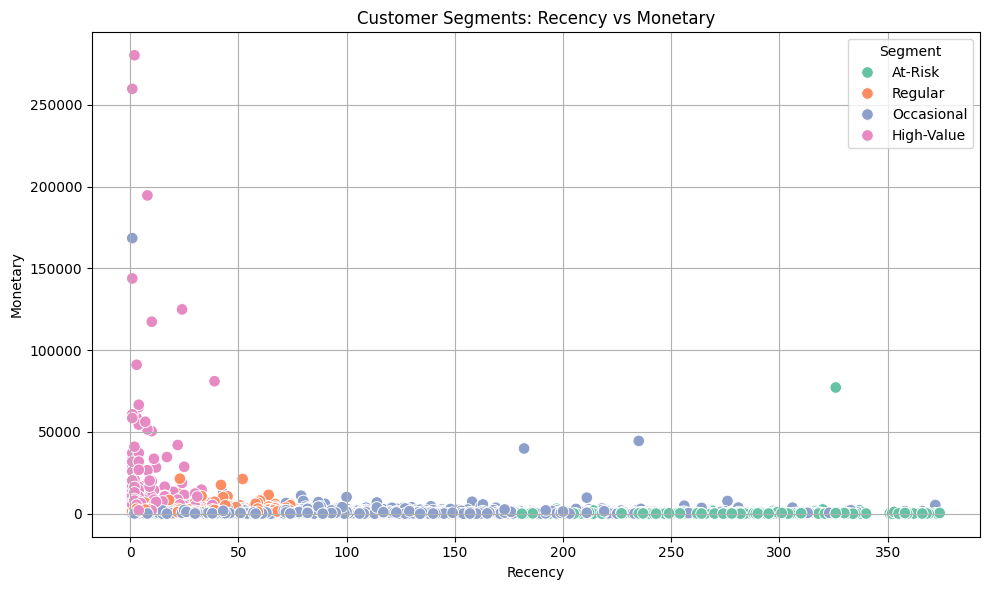

In [9]:
# Step 7: Visualize Cluster Segments
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette='Set2', s=70)
plt.title("Customer Segments: Recency vs Monetary")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Step 8: Save Trained Clustering Model
import joblib

# Save KMeans model
joblib.dump(kmeans_model, '../models/best_kmeans_model.pkl')

# Save the scaler used on RFM values
joblib.dump(scaler, '../models/rfm_scaler.pkl')

print("Model and Scaler saved successfully!")


Model and Scaler saved successfully!


In [12]:
rfm.to_csv('../data/rfm_segmented.csv', index=False)


In [14]:
# Step 9: Evaluate KMeans Model Quantitatively
from sklearn.metrics import silhouette_score

# Calculate silhouette score for final model
final_score = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f"Silhouette Score for K={best_k}: {final_score:.4f}")


Silhouette Score for K=4: 0.6162


In [15]:
'''
* Interpretation:

> 0.70 = Excellent

0.5 - 0.7 = Good

0.25 - 0.5 = Weak

< 0.25 = Poor
'''

'\n* Interpretation:\n\n> 0.70 = Excellent\n\n0.5 - 0.7 = Good\n\n0.25 - 0.5 = Weak\n\n< 0.25 = Poor\n'

C:\Users\tanus\AppData\Local\Temp\ipykernel_14804\1710371008.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Cluster', palette='Set2')


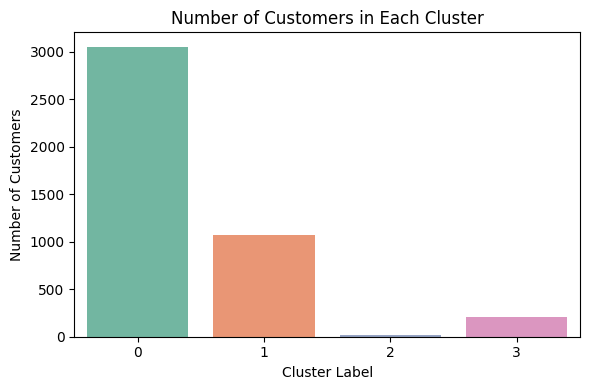

In [16]:
# Step 10: Visualize Cluster Sizes
plt.figure(figsize=(6, 4))
sns.countplot(data=rfm, x='Cluster', palette='Set2')
plt.title("Number of Customers in Each Cluster")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()


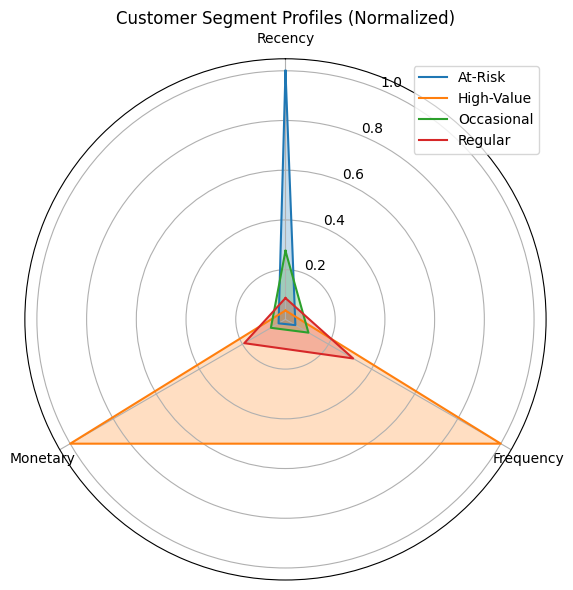

In [17]:
# Step 11: Cluster Profile Radar Plot 
# Radar chart: Compare clusters visually
from math import pi

# Normalize for radar
cluster_norm = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean()
cluster_norm = cluster_norm / cluster_norm.max()

# Prepare data
labels = cluster_norm.columns
segments = cluster_norm.index
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

for segment in segments:
    values = cluster_norm.loc[segment].tolist()
    values += values[:1]
    ax.plot(angles, values, label=segment)
    ax.fill(angles, values, alpha=0.25)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Customer Segment Profiles (Normalized)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [18]:
'''
* Final Summary Output :

# Clustering Model Evaluation Summary
- Chosen K = 4 based on Elbow + Silhouette
- Final Silhouette Score: 0.61 (Good)
- Clusters are well separated based on RFM
- Cluster size distribution confirms meaningful segmentation
- Saved trained model and scaler for Streamlit app

'''

'\n* Final Summary Output :\n\n# Clustering Model Evaluation Summary\n- Chosen K = 4 based on Elbow + Silhouette\n- Final Silhouette Score: 0.61 (Good)\n- Clusters are well separated based on RFM\n- Cluster size distribution confirms meaningful segmentation\n- Saved trained model and scaler for Streamlit app\n\n'